# ANN predicción de trabajadores

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from keras.models import Sequential 
from keras.layers import Dense
from keras.regularizers import l2

In [2]:
data = pd.read_csv('aug_train.csv',sep=',')
data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


### Exploración, análisis, limpieza, estadísticas y equilibrio de la data entregada

In [3]:
data.isnull().sum(axis=0)

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [4]:
print("Dimensiones de nuestra data sin limpiar: ",(data.shape))

Dimensiones de nuestra data sin limpiar:  (19158, 14)


In [5]:
# Porcentaje de valores nulos en las columnas.
na_ratio = ((data.isnull().sum() / len(data))*100).sort_values(ascending = False)
print("Procentajes de valores nulos para las columnas\n", na_ratio)

Procentajes de valores nulos para las columnas
 company_type              32.049274
company_size              30.994885
gender                    23.530640
major_discipline          14.683161
education_level            2.401086
last_new_job               2.207955
enrolled_university        2.014824
experience                 0.339284
enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
relevent_experience        0.000000
training_hours             0.000000
target                     0.000000
dtype: float64


In [6]:
# Busqueda de filas totalmente nulas
k=0;
# data.isnull().sum(axis = 1) nos permite obtener el total de campos vacios en una fila
for i in data.isnull().sum(axis=1):
  if i > 10:
    k+=1
print("Porcentaje de filas mayoritariamente vacías: ", (k/len(data)*100))


Porcentaje de filas mayoritariamente vacías:  0.0


##### Como vemos no existen filas totalmente vacías, pero si columnas con algunos datos faltantes, si eliminamos las filas que contienen algún campo vacío entonces nos quedamos con el 47.4% de la data original, lo cual no es óptimo, una mejor alternativa es llenar estos espacios vacíos en las columnas a partir de los datos que disponemos, utilizaremos MICE de la librería sklearn

In [7]:
# declaramos un imputador que rellenará los datos faltantes
imputador = IterativeImputer()
data_completa = data.copy()

In [8]:
# Asignamos valores numéricos para las variables categóricas ayudados de la función map

data_completa['company_type'] = data_completa['company_type'].map(
    {'Pvt Ltd':int(0), 'Funded Startup':int(-1), 'Early Stage Startup':int(2), 
     'Other':int(3),'Public Sector':int(4), 'NGO':int(5)}
    )

data_completa['company_size'] = data_completa['company_size'].map(
    {'50-99':int(0), '<10':int(-1), '10000+':int(1), '5000-9999':int(2), 
    '1000-4999':int(3), '10/49':int(4), '100-500':int(5),'500-999':int(6)}
    )

data_completa['gender'] = data_completa['gender'].map(
    {'Female':int(0),'Male':int(1) ,'Other':int(-1)}
    )

data_completa['major_discipline'] = data_completa['major_discipline'].map(
    {'STEM':int(-1) ,'Business Degree':int(0), 'Arts':int(1) ,
     'Humanities':int(2) ,'No Major':int(3) ,'Other':int(4)}
    )

data_completa['education_level'] = data_completa['education_level'].map(
    {'Graduate':int(0),'Masters':int(1) ,'High School':int(-1),'Phd':int(2),'Primary School':int(3)}
    )

data_completa['last_new_job'] = data_completa['last_new_job'].map(
    {'1':int(-1), '>4':int(0), 'never':int(1), '4':int(4), '3':int(3), '2':int(2)}
    )

data_completa['enrolled_university'] = data_completa['enrolled_university'].map(
    {'no_enrollment':int(0),'Full time course':int(1) ,'Part time course':int(-1)}
    )

data_completa['experience'] = data_completa['experience'].map(
    {'>20':int(20), '15':int(15),  '5':int(5), 
     '<1':int(-1), '11':int(11), 
     '13':int(13), '7':int(7), '17':int(17),
     '2':int(7), '16':int(16), '1':int(1), '4':int(4), '10':int(10),
     '14':int(14), '18':int(18),'19':int(19), '12':int(12), '3':int(3), 
     '6':int(6), '9':int(9), '8':int(8), '20':int(20)}
    )

In [9]:
# Categorizamos estas variables que no tienen valores nulos
data_completa['city'] = pd.Categorical(data_completa['city']).codes
data_completa['relevent_experience'] = pd.Categorical(data_completa['relevent_experience']).codes

In [10]:
# ahora que tenemos variables ordinales podemos utilizar MICE
data_completa['company_type']= imputador.fit_transform(data_completa[['company_type']])
data_completa['company_type'] = round(data_completa['company_type'])

data_completa['company_size']= imputador.fit_transform(data_completa[['company_size']])
data_completa['company_size'] = round(data_completa['company_size'])

data_completa['gender'] = imputador.fit_transform(data_completa[['gender']])
data_completa['gender'] = round(data_completa['gender'])

data_completa['major_discipline']= imputador.fit_transform(data_completa[['major_discipline']])
data_completa['major_discipline'] = round(data_completa['major_discipline'])

data_completa['education_level'] = imputador.fit_transform(data_completa[['education_level']])
data_completa['education_level'] = round(data_completa['education_level'])

data_completa['last_new_job'] = imputador.fit_transform(data_completa[['last_new_job']])
data_completa['last_new_job'] = round(data_completa['last_new_job'])

data_completa['enrolled_university'] = imputador.fit_transform(data_completa[['enrolled_university']])
data_completa['enrolled_university'] = round(data_completa['enrolled_university'])

data_completa['experience']= imputador.fit_transform(data_completa[['experience']])
data_completa['experience'] = round(data_completa['experience'])

In [11]:
print("Dimensiones de la data rellenada con MICE: ",data_completa.shape)
ratio = ((data_completa.isnull().sum() / len(data_completa))*100).sort_values(ascending = False)
print("Procentajes de valores nulos para las columnas después de MICE: \n", ratio)

Dimensiones de la data rellenada con MICE:  (19158, 14)
Procentajes de valores nulos para las columnas después de MICE: 
 enrollee_id               0.0
city                      0.0
city_development_index    0.0
gender                    0.0
relevent_experience       0.0
enrolled_university       0.0
education_level           0.0
major_discipline          0.0
experience                0.0
company_size              0.0
company_type              0.0
last_new_job              0.0
training_hours            0.0
target                    0.0
dtype: float64


##### Ahora que ya no tenemos valores nulos en los datos procedemos a equilibrar la data

In [12]:
# Visualicemos la frecuencia con respecto al target
frecuencia = pd.value_counts(data_completa.target).to_frame().reset_index()
frecuencia.insert(2,"Interpretación",['No busca cambio de trabajo','Desea un cambio de trabajo'],True)
frecuencia.rename(columns={"index":"Target","target":"Frecuencia"})


,Target,Frecuencia,Interpretación
0,0.0,14381,No busca cambio de trabajo
1,1.0,4777,Desea un cambio de trabajo


##### Al no estar equilibrada separamos los datos de aquellos que buscan un cambio y los que no, después se tomará una muestra correspondiente al  33,22%

In [13]:
data_no_cambio = data_completa.loc[data_completa['target'] == 0]
data_cambio = data_completa.loc[data_completa['target'] == 1]

data_no_cambio_subset = data_no_cambio.sample(frac=(4777/14381), random_state=1)
data_equilibrada = pd.concat([data_no_cambio_subset, data_cambio])
data_equilibrada.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
14177,19233,5,0.920,1.0,0,0.0,0.0,-1.0,20.0,3.0,0.0,0.0,56,0.0
7493,24920,91,0.913,1.0,0,0.0,0.0,-1.0,20.0,5.0,0.0,0.0,72,0.0
6635,33083,69,0.848,1.0,0,0.0,0.0,-1.0,10.0,0.0,0.0,1.0,27,0.0
12694,17031,48,0.910,1.0,0,0.0,0.0,-1.0,3.0,4.0,0.0,-1.0,43,0.0
12975,14309,49,0.920,1.0,0,0.0,0.0,-1.0,20.0,4.0,0.0,0.0,20,0.0


#### Análisis de métricas estadísticas para descartar variables que sean poco útiles en la predicción

In [14]:
# Podríamos usar un coeficiente de Pearson para ver la poca utilidad del id, no se acerca a valores de -1 o 1
stats.pearsonr(data_equilibrada['enrollee_id'][data_equilibrada['target'] == 0], 
             data_equilibrada['enrollee_id'][data_equilibrada['target'] == 1])

(0.009647927868348234, 0.5049856990304562)

In [15]:
# Utilizamos diferencia de medias dado que tenemos variable cuantitativa y cualitativa

stats.f_oneway(data_equilibrada['city'][data_equilibrada['target'] == 0], 
             data_equilibrada['city'][data_equilibrada['target'] == 1])

F_onewayResult(statistic=45.42905642448366, pvalue=1.674173472303798e-11)

In [16]:
stats.f_oneway(data_equilibrada['enrolled_university'][data_equilibrada['target'] == 0], 
             data_equilibrada['enrolled_university'][data_equilibrada['target'] == 1])

F_onewayResult(statistic=170.61384106073444, pvalue=1.1638991360956965e-38)

In [17]:
del data_equilibrada['gender']
del data_equilibrada['enrollee_id']
del data_equilibrada['city']
del data_equilibrada['enrolled_university']

data_equilibrada.head()

,city_development_index,relevent_experience,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
14177,0.920,0,0.0,-1.0,20.0,3.0,0.0,0.0,56,0.0
7493,0.913,0,0.0,-1.0,20.0,5.0,0.0,0.0,72,0.0
6635,0.848,0,0.0,-1.0,10.0,0.0,0.0,1.0,27,0.0
12694,0.910,0,0.0,-1.0,3.0,4.0,0.0,-1.0,43,0.0
12975,0.920,0,0.0,-1.0,20.0,4.0,0.0,0.0,20,0.0


##### Dimensiones de data después de MICE, equilibrar y estadísticas

In [18]:
data_equilibrada.shape

(9554, 10)

#### Ahora que ya tenemos nuestros datos limpios consideremos algunos histogramas de las variables para decidir nuestras capas a ser usadas.

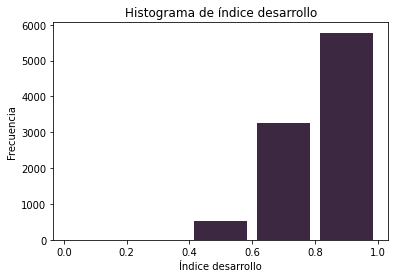

In [19]:
datos_city_development = pd.Series(data_equilibrada['city_development_index'])
intervalos = [0.0, 0.2, 0.4, 0.6, 0.8,1.0]
plt.hist(x=datos_city_development, bins=intervalos, color='#3D2841', rwidth=0.85)
plt.title('Histograma de índice desarrollo')
plt.xlabel('Índice desarrollo')
plt.ylabel('Frecuencia')
plt.xticks(intervalos)

plt.show()

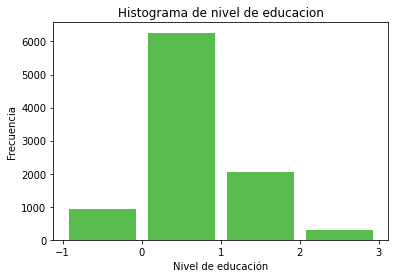

In [20]:
datos_education = pd.Series(data_equilibrada['education_level'])
intervalos = [-1,0,1,2,3]
plt.hist(x=datos_education, bins=intervalos, color='#58BD4E', rwidth=0.85)
plt.title('Histograma de nivel de educacion')
plt.xlabel('Nivel de educación')
plt.ylabel('Frecuencia')
plt.xticks(intervalos)

plt.show()

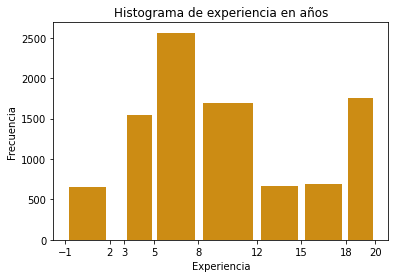

In [21]:
datos_experience = pd.Series(data_equilibrada['experience'])
intervalos = [-1,2,3,5,8,12,15,18,20]
plt.hist(x=datos_experience, bins=intervalos, color='#CC8C14', rwidth=0.85)
plt.title('Histograma de experiencia en años')
plt.xlabel('Experiencia')
plt.ylabel('Frecuencia')
plt.xticks(intervalos)

plt.show()

### Modelo de ANN

In [22]:
train,test=train_test_split(data_equilibrada,train_size=0.8, random_state = 1)
# Datos de entrada para el entrenamiento
#x entrada
x_train = train.values[:,0:9]
#y targets
y_train = train.values[:,9]

#Datos para el test
#x entrada
x_test = test.values[:,0:9]
#y targets
y_test = test.values[:,9]

In [23]:

model = Sequential()
model.add(Dense(9, input_dim=9, activation='selu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(18,activation='tanh'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error',optimizer='adam', metrics=['binary_accuracy'])

numero_epocas = 350
 
history = model.fit(x_train, y_train, epochs=numero_epocas)
 
# evaluamos el modelo
scores = model.evaluate(x_train, y_train)

#impresión de resultados
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print (model.predict(x_train).round())



Epoch 1/350
239/239 [==============================] - 1s 819us/step - loss: 0.2643 - binary_accuracy: 0.5259
Epoch 2/350
239/239 [==============================] - 0s 881us/step - loss: 0.2456 - binary_accuracy: 0.5630
Epoch 3/350
239/239 [==============================] - 0s 836us/step - loss: 0.2426 - binary_accuracy: 0.5823
Epoch 4/350
239/239 [==============================] - 0s 878us/step - loss: 0.2436 - binary_accuracy: 0.5738
Epoch 5/350
239/239 [==============================] - 0s 819us/step - loss: 0.2412 - binary_accuracy: 0.5902
Epoch 6/350
239/239 [==============================] - 0s 824us/step - loss: 0.2393 - binary_accuracy: 0.5860
Epoch 7/350
239/239 [==============================] - 0s 794us/step - loss: 0.2397 - binary_accuracy: 0.5970
Epoch 8/350
239/239 [==============================] - 0s 794us/step - loss: 0.2373 - binary_accuracy: 0.6051
Epoch 9/350
239/239 [==============================] - 0s 782us/step - loss: 0.2386 - binary_accuracy: 0.6008
Epoch 10/3

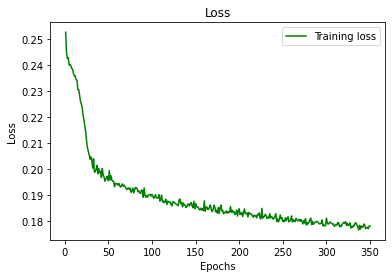

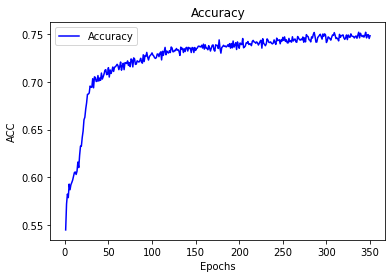

In [24]:
# Gráfica de loss vs epochs
loss_train = history.history['loss']
acc = history.history['binary_accuracy']
epochs = range(1,numero_epocas+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Gráfica de acc vs epochs
plt.plot(epochs, acc, 'b', label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.show()





In [25]:
# test
y_pred_test = model.predict(x_test)
# redondeamos las predicciones
rounded_y_pred_test = [round(x[0]) for x in y_pred_test]

scores_test = model.evaluate(x_test,y_test)
print("Accuracy con test: \n%s: %.2f%%" % (model.metrics_names[1], scores_test[1]*100))#Accuracy (exactitud)


60/60 [==============================] - 0s 602us/step - loss: 0.1971 - binary_accuracy: 0.7248
Accuracy con test: 
binary_accuracy: 72.48%
